In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [ ]:
spark = SparkSession.builder.appName('Ml_spark').config('spark.memory.offHeap.enabled', 'true').config('spark.memory.offHeap.size', '10g').getOrCreate()

In [ ]:
spark

In [ ]:
df = spark.read.csv('/content/OnlineRetail.csv', header=True, inferSchema=True)
spark.catalog.listTables()
df.createOrReplaceTempView('Data')

In [ ]:
df.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows



- InvoiceNo: The unique identifier of each customer invoice.
- StockCode: The unique identifier of each item in stock.
- Description: The item purchased by the customer.
- Quantity: The number of each item purchased by a customer in a single invoice.
- InvoiceDate: The purchase date.
- UnitPrice: Price of one unit of each item.
- CustomerID: Unique identifier assigned to each user.
- Country: The country from where the purchase was made

In [ ]:
query = '''select StockCode, Description
from Data'''
result = spark.sql(query)
result.show()

+---------+--------------------+
|StockCode|         Description|
+---------+--------------------+
|   85123A|WHITE HANGING HEA...|
|    71053| WHITE METAL LANTERN|
|   84406B|CREAM CUPID HEART...|
|   84029G|KNITTED UNION FLA...|
|   84029E|RED WOOLLY HOTTIE...|
|    22752|SET 7 BABUSHKA NE...|
|    21730|GLASS STAR FROSTE...|
|    22633|HAND WARMER UNION...|
|    22632|HAND WARMER RED P...|
|    84879|ASSORTED COLOUR B...|
|    22745|POPPY'S PLAYHOUSE...|
|    22748|POPPY'S PLAYHOUSE...|
|    22749|FELTCRAFT PRINCES...|
|    22310|IVORY KNITTED MUG...|
|    84969|BOX OF 6 ASSORTED...|
|    22623|BOX OF VINTAGE JI...|
|    22622|BOX OF VINTAGE AL...|
|    21754|HOME BUILDING BLO...|
|    21755|LOVE BUILDING BLO...|
|    21777|RECIPE BOX WITH M...|
+---------+--------------------+
only showing top 20 rows



In [ ]:
# EDA
df.count()

541909

In [ ]:
query1 = '''select count(distinct(CustomerID))
from Data'''
result1 = spark.sql(query1)
result1.show()

+--------------------------+
|count(DISTINCT CustomerID)|
+--------------------------+
|                      4372|
+--------------------------+



In [ ]:
# What country do most purchases come from?
df.groupBy('Country').agg(countDistinct('CustomerID').alias('Country Count')).show()

+------------------+-------------+
|           Country|Country Count|
+------------------+-------------+
|            Sweden|            8|
|         Singapore|            1|
|           Germany|           95|
|               RSA|            1|
|            France|           87|
|            Greece|            4|
|European Community|            1|
|           Belgium|           25|
|           Finland|           12|
|             Malta|            2|
|       Unspecified|            4|
|             Italy|           15|
|              EIRE|            3|
|         Lithuania|            1|
|            Norway|           10|
|             Spain|           31|
|           Denmark|            9|
|         Hong Kong|            0|
|            Israel|            4|
|           Iceland|            1|
+------------------+-------------+
only showing top 20 rows



In [ ]:
df.groupBy('Country').agg(countDistinct('CustomerID').alias('Country Count')).orderBy(desc('Country Count')).show()

+---------------+-------------+
|        Country|Country Count|
+---------------+-------------+
| United Kingdom|         3950|
|        Germany|           95|
|         France|           87|
|          Spain|           31|
|        Belgium|           25|
|    Switzerland|           21|
|       Portugal|           19|
|          Italy|           15|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|        Denmark|            9|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|         Sweden|            8|
|         Cyprus|            8|
|          Japan|            8|
|         Poland|            6|
|         Greece|            4|
+---------------+-------------+
only showing top 20 rows



In [ ]:
# When was the most recent purchase made by a customer on the e-commerce platform?
spark.sql('set spark.sql.legacy.timeParserPolicy=LEGACY')
df = df.withColumn('date', to_timestamp("InvoiceDate", 'dd/MM/YY HH:mm'))
df.select(max('date')).show()

+-------------------+
|          max(date)|
+-------------------+
|2010-12-26 20:38:00|
+-------------------+



In [ ]:
# When was the earliest purchase made by a customer on the e-commerce platform?
df.select(min('date')).show()

+-------------------+
|          min(date)|
+-------------------+
|2009-12-27 07:48:00|
+-------------------+



In [ ]:
# Data Pre-processing
df.show(5,0)

+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|CustomerID|Country       |date               |
+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+-------------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/2010 8:26|2.55     |17850     |United Kingdom|2009-12-27 08:26:00|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|2009-12-27 08:26:00|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/2010 8:26|2.75     |17850     |United Kingdom|2009-12-27 08:26:00|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|2009-12-27 08:26:00|
|536365   |84029E   |RED WOOLLY HO

In [ ]:
# RFM is commonly used in marketing to evaluate a client’s segmentation
- Recency
- Frequency
- Monetory

In [ ]:
#Recency
# i) Assign a recency score to each customer
df = df.withColumn("from_date", lit("12/1/2010 8:26"))
df = df.withColumn('from_date', to_timestamp("from_date", 'dd/MM/YY HH:mm'))

df2 = df.withColumn('from_date', to_timestamp(col('from_date'))).withColumn('recency', col("date").cast("long") - col('from_date').cast("long"))

In [ ]:
# ii) Select the most recent purchase
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')), on='recency', how='leftsemi')

In [ ]:
df2.show()

+-------+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+-------------------+
|recency|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|               date|          from_date|
+-------+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+-------------------+
|   4260|   536378|    22386|JUMBO BAG PINK PO...|      10|12/1/2010 9:37|     1.95|     14688|United Kingdom|2009-12-27 09:37:00|2009-12-27 08:26:00|
|   4260|   536378|   85099C|JUMBO  BAG BAROQU...|      10|12/1/2010 9:37|     1.95|     14688|United Kingdom|2009-12-27 09:37:00|2009-12-27 08:26:00|
|   4260|   536378|    21033|JUMBO BAG CHARLIE...|      10|12/1/2010 9:37|     2.95|     14688|United Kingdom|2009-12-27 09:37:00|2009-12-27 08:26:00|
|   4260|   536378|    20723|STRAWBERRY CHARLO...|      10|12/1/2010 9:37|     0.85|     14688

In [ ]:
df2.printSchema()

root
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)



In [ ]:
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency'))

In [ ]:
df_freq.show()

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|     17389|      222|
|     15727|      235|
|     15447|        9|
|     16503|       54|
|     14450|       40|
|     13623|       86|
|     13285|      187|
|     16339|       20|
|     14570|       29|
|     16386|       88|
|     17420|       23|
|     16861|        6|
|     18024|       22|
|     12471|      423|
|     16916|      143|
|     15100|        3|
|     14514|       73|
|     16500|       11|
|     12626|      307|
|     18161|       69|
+----------+---------+
only showing top 20 rows



In [ ]:
df3 = df2.join(df_freq,on='CustomerID',how='inner')

In [ ]:
df3.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- frequency: long (nullable = false)



In [ ]:
# i) Find the total amount spent in each purchase:
m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))
m_val.show()

+----------+-------+---------+---------+--------------------+--------+--------------+---------+--------------+-------------------+-------------------+---------+------------------+
|CustomerID|recency|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|       Country|               date|          from_date|frequency|       TotalAmount|
+----------+-------+---------+---------+--------------------+--------+--------------+---------+--------------+-------------------+-------------------+---------+------------------+
|     14688|   4260|   536378|    22386|JUMBO BAG PINK PO...|      10|12/1/2010 9:37|     1.95|United Kingdom|2009-12-27 09:37:00|2009-12-27 08:26:00|      354|              19.5|
|     14688|   4260|   536378|   85099C|JUMBO  BAG BAROQU...|      10|12/1/2010 9:37|     1.95|United Kingdom|2009-12-27 09:37:00|2009-12-27 08:26:00|      354|              19.5|
|     14688|   4260|   536378|    21033|JUMBO BAG CHARLIE...|      10|12/1/2010 9:37|     2.95|Unite

In [ ]:
# ii) Find the total amount spent by each customer:
m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))
m_val.show()

+----------+------------------+
|CustomerID|    monetary_value|
+----------+------------------+
|     17389|          31203.18|
|     15727|3642.1100000000015|
|     15447|            155.17|
|     16503| 943.8399999999999|
|     14450|            483.25|
|     13623|            672.44|
|     13285|2709.1199999999994|
|     16339|109.95000000000002|
|     14570|218.05999999999992|
|     16386|             317.2|
|     17420|            467.98|
|     16861|            173.76|
|     18024|236.78000000000003|
|     12471|          14727.65|
|     16916| 576.2599999999999|
|     15100|              65.7|
|     14514|           1055.35|
|     16500|            400.86|
|     12626| 6388.350000000001|
|     18161|            1368.0|
+----------+------------------+
only showing top 20 rows



In [ ]:
# Merge all
finaldf = m_val.join(df3,on='CustomerID',how='inner')
finaldf = finaldf.select(['recency','frequency','monetary_value','CustomerID']).distinct()

In [ ]:
finaldf.show()

+--------+---------+------------------+----------+
| recency|frequency|    monetary_value|CustomerID|
+--------+---------+------------------+----------+
|31481160|      222|          31203.18|     17389|
|31473600|      235|3642.1100000000015|     15727|
|31476120|      222|          31203.18|     17389|
|31460400|        9|            155.17|     15447|
|31464360|       54| 943.8399999999999|     16503|
|31454880|      222|          31203.18|     17389|
|31478880|      222|          31203.18|     17389|
|31462020|       40|            483.25|     14450|
|31468320|      222|          31203.18|     17389|
|31473960|      222|          31203.18|     17389|
|31476660|      222|          31203.18|     17389|
|31465740|       86|            672.44|     13623|
|31466520|       86|            672.44|     13623|
|31481220|      187|2709.1199999999994|     13285|
|31468500|       20|109.95000000000002|     16339|
|31462440|      222|          31203.18|     17389|
|31457580|       29|218.0599999

In [ ]:
# Standardization
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')

assembled_data=assemble.transform(finaldf)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

In [ ]:
data_scale_output.select('standardized').show(2,truncate=False)

+----------------------------------------------------------+
|standardized                                              |
+----------------------------------------------------------+
|[6.448843551339409,0.2419106691309331,1.2344889867335547] |
|[6.44729490264768,0.25607660921517694,0.14409251504084356]|
+----------------------------------------------------------+
only showing top 2 rows



In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

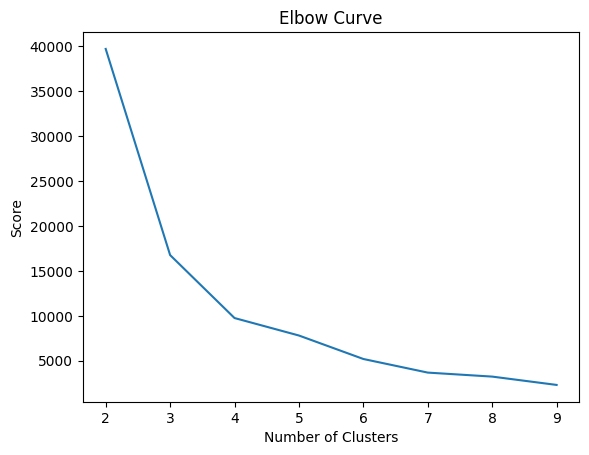

In [ ]:
import pandas as pd
import pylab as pl
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [ ]:
# Building K-Mean Clustring
KMeans_algo=KMeans(featuresCol='standardized', k=4)
KMeans_fit=KMeans_algo.fit(data_scale_output)

In [ ]:
# Making Prediction
preds=KMeans_fit.transform(data_scale_output)

preds.show(5,0)

+--------+---------+------------------+----------+------------------------------------+---------------------------------------------------------------+----------+
|recency |frequency|monetary_value    |CustomerID|features                            |standardized                                                   |prediction|
+--------+---------+------------------+----------+------------------------------------+---------------------------------------------------------------+----------+
|31481160|222      |31203.18          |17389     |[3.148116E7,222.0,31203.18]         |[6.448843551339409,0.2419106691309331,1.2344889867335547]      |0         |
|31473600|235      |3642.1100000000015|15727     |[3.14736E7,235.0,3642.1100000000015]|[6.44729490264768,0.25607660921517694,0.14409251504084356]     |0         |
|31476120|222      |31203.18          |17389     |[3.147612E7,222.0,31203.18]         |[6.447811118878255,0.2419106691309331,1.2344889867335547]      |0         |
|31460400|9        |15

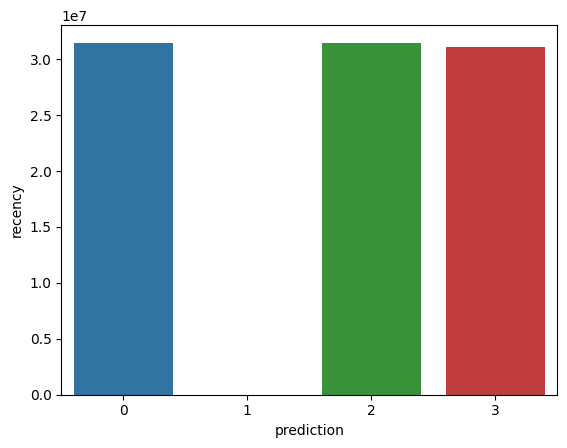

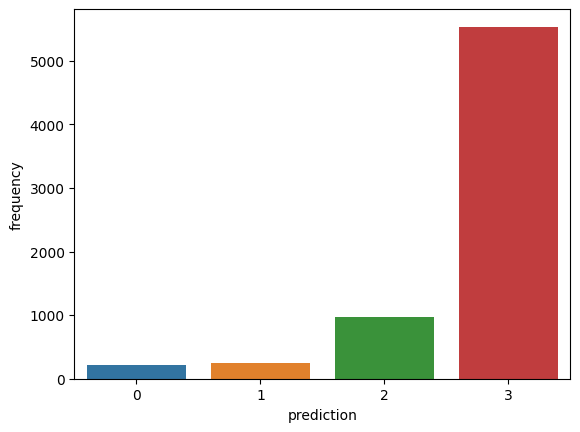

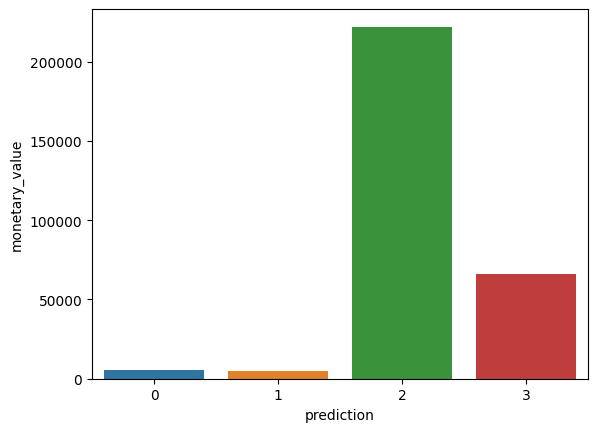

In [ ]:
# Cluster Analysis
import matplotlib.pyplot as plt
import seaborn as sns

df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()

* __Cluster 0__: Customers in this segment display low recency, frequency, and monetary value. They rarely shop on the platform and are low potential customers who are likely to stop doing business with the ecommerce company.
* __Cluster 1__: Users in this cluster display high recency but haven’t been seen spending much on the platform. They also don’t visit the site often. This indicates that they might be newer customers who have just started doing business with the company.
* __Cluster 2__: Customers in this segment display medium recency and frequency and spend a lot of money on the platform. This indicates that they tend to buy high-value items or make bulk purchases.
* __Cluster 3__: The final segment comprises users who display high recency and make frequent purchases on the platform. However, they don’t spend much on the platform, which might mean that they tend to select cheaper items in each purchase.